In [457]:
# Imports to get and work with files
import os
import csv

# Standard DS 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Image analysis
import cv2
import imutils
from PIL import Image

## Process / Workflow
1. read image and convert to grayscale
2. calculate magnitude by using vertical and horizontal Sobel edge detectors
3. add a border to the image of 15 pixels, color = white (255)
4. use Hu Moments to calculate moments which will be saved as the image vectors

In [492]:
class ShapeDescriptor:
    def describe(self, image, border = True):
        
        # convert image to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # blur the image
        image = cv2.medianBlur(image, 5)
        
        # add a border to the image if border = True
        if border:
            image = cv2.copyMakeBorder( image, 15, 15, 15, 15,
                                        cv2.BORDER_CONSTANT, 
                                        value = 255 )
        
        # Use adaptive threshold to create a black and white silhouette
        threshold = cv2.adaptiveThreshold( image, 
                                           255,
                                           cv2.ADAPTIVE_THRESH_MEAN_C,
                                           cv2.THRESH_BINARY, 
                                           31, 
                                           1 )
        
        # use Zernike Moments to create image feature vector
        moments = mahotas.features.zernike_moments(threshold, 31)
        hist = moments[1:]
        
        # log transform the moments
        hist = np.log(hist)

        # return hist as the image feature vector
        return hist
        
        

In [459]:
class ImageSearchUtils:
    """
    Class for utilites, helper functions, and preprocessing / cleaning functions used in the
    Image search engine project
    """
    
    def get_image_file_names(dir_path, make_a_id=False):
        """
        Go to specified directory, find all image/.png files, add them to a list and return that list of names.

        If make_a_id is True, create a_id using image file name to match id's used in other areas of the business
        e.g. change '1980.001.png' to 'a1980_001'

        ----------
        Parameters
        ----------
        dir_path: string, directory path to look through.

        return: list, list of strings of file names.
        """

        # set up empty list which will hold file names
        image_name_list = []

        # loop though directory, check to see if the file is a png and if so add to list
        for file in os.listdir(dir_path):
            # check to see if the file is a .png
            if file.endswith('png'):
                # check to see if make_a_id is True and the file name needs to be changed
                if make_a_id:
                        image_name_list.append('a'+file.replace('.', '_')[:-4])
                # if make_a_id is False get .png file name and add it to list
                else:        
                    image_name_list.append(file)

        # return list of image file names
        return image_name_list



In [462]:
# set path / directory variable to where images are
path = r'C:/Users/Andrew/Documents/GitHub/Content_Based_Image_Retrieval_System/Paintings/'

# get a list of image file names and a_id names
# .png file names
img_f_names = ImageSearchUtils.get_image_file_names(path)
# a_id formated names
aid_list = ImageSearchUtils.get_image_file_names(path, make_a_id=True)

In [494]:
# initalize descriptor object
shape_desc = ShapeDescriptor()

# open output file for writing
output = open('shape_image_features_adaptive.csv', 'w')

# loop over both image file names and ID's
for image_path, a_id in zip(img_f_names, aid_list):
   
    # set the image ID
    image_id = a_id
    
    # read the image
    image = cv2.imread(path + image_path)
    
    # convert the iamge to grayscale and get features
    hist = shape_desc.describe(image)
    
    # write ID and features to the file
    features = [str(f) for f in hist]
    output.write("%s, %s\n" % (image_id, ",".join(features)))

# close the output file
output.close()

In [495]:
class SimilarityRanking:
    def __init__(self, indexPath):
        """
        Set directory path for the file of image vectors.
        
        ----------
        Parameters
        ----------
        indexPath : srting, directory path to image vectors.
        
        return    : Doesn't return anythin just sets the indexPath variable
        """
        # set the indexPath to where the image vector file is
        self.indexPath = indexPath
        
        
    def search(self, queryFeatures, metric = 'chi-squared', limit = 26):
        """
        
        """
        
        # initialize results dictionary
        results = {}
        
        # open the file to read image vectors
        with open(self.indexPath) as f:
            # initiate the CSV reader
            reader = csv.reader(f)
            
            # loop over the rows
            for row in reader:
                # parse out the image ID and feature vector, then compute
                # the distance between features in our file and the image
                # being queried
                features = [float(x) for x in row[1:]]
                
                # calculate the distance from the image and the query image
                # default chi-squared but user can choose between those below
                if metric == 'chi-squared':
                    dist = self.chi2_distance(features, queryFeatures)
                elif metric == 'euclidean':
                    pass
                elif metric == 'cosine':
                    pass
                elif metric == 'minkowski':
                    pass
                
                # once we have the distance, upadte results dictionary using
                # the image ID as the key and the distance as the value, the
                # distance represents similar of the image to the query image
                results[row[0]] = dist
                
            # close the reader
            f.close
            
        # sort the results smallest to largest
        results = sorted( [(v, k) for (k, v) in results.items()] )
        
        # return the results limited by limit parameter
        return results[1:limit]
                
    
    def chi2_distance(self, histA, histB, eps = 1e-10):
        """
        
        """
        
        # compute the chi-squared distance
        dist = 0.5 * np.sum( [ ((a - b) ** 2) / (a + b + eps) 
                              for (a, b) in zip(histA, histB) ] )
        
        # return the chi-squared distance
        return dist
        
        

In [509]:
# set an image to query
painting = path+'1974.001.png'
query = cv2.imread(painting)
features = shape_desc.describe(query)

# perform the search
searcher = SimilarityRanking('shape_image_features_adaptive.csv')
results = searcher.search(features)
result_images = [x[1].replace('a','').replace('_','.') for x in results]

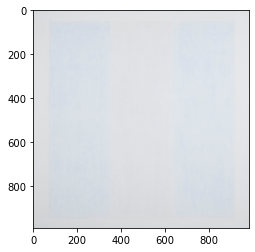

In [510]:
img = Image.open(painting)
plt.imshow(img);

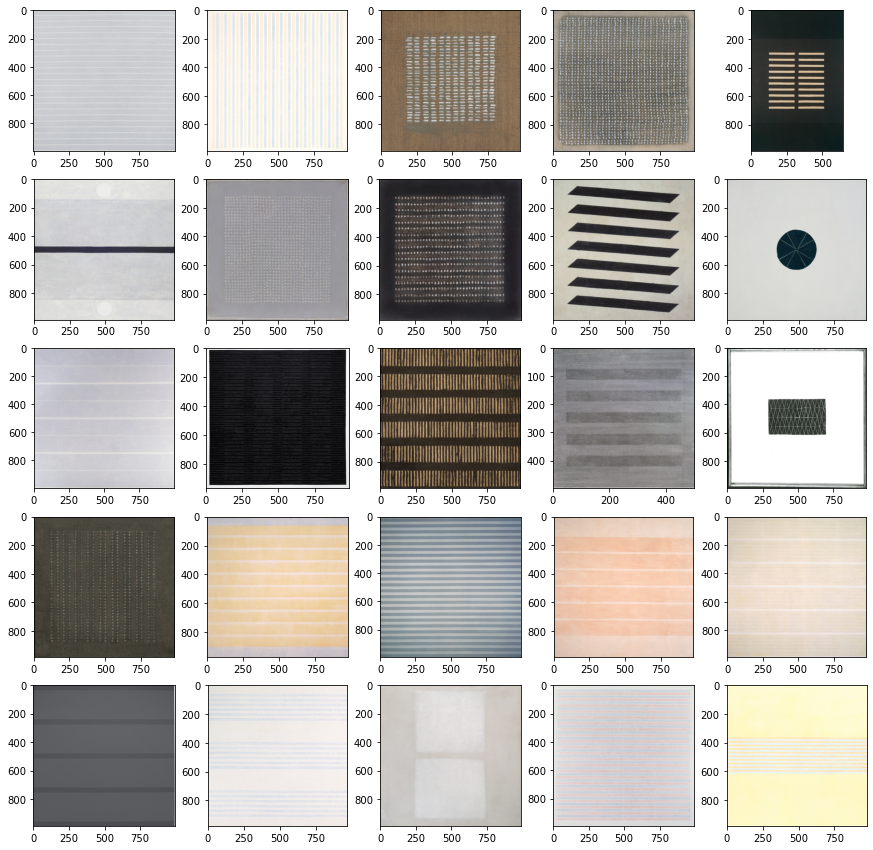

In [511]:
plt.figure(figsize=(15,15)) # specifying the overall grid size
for i in range(25):
    plt.subplot(5,5,i+1)
    img = Image.open(path + result_images[i] + '.png')
    plt.imshow(img)
plt.show()

### Test adaptive thresholding

In [480]:
path = (r'C:/Users/Andrew/Documents/GitHub/Content_Based_Image_Retrieval_System/Paintings/')
image = cv2.imread(path + '2001.011.png')
blur = cv2.medianBlur(image, 11)
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

gray = cv2.copyMakeBorder(
                gray, 15, 15, 15, 15,
                cv2.BORDER_CONSTANT, 
                value = 255
            )

th3 = cv2.adaptiveThreshold(
    gray,255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY, 
    31, 
    1)

moments = mahotas.features.zernike_moments(th3, 31)
hist = np.log(moments[1:])
hist = np.nan_to_num(hist)

hist 
# plt.plot(hist);
# plt.imshow(th3, cmap='gray');

array([-3.06015607, -1.89177088, -1.88890336, -2.17815691, -2.18792593,
       -2.50474919, -2.49048675, -2.54484679, -5.75882857, -5.20309248,
       -3.83489938, -6.90098496, -6.04313638, -5.56083787, -3.70660167,
       -2.63514279, -2.72982093, -2.75667078, -2.47426377, -3.70778178,
       -3.82645809, -4.1007486 , -4.43909295, -2.90633239])

In [481]:
path = (r'C:/Users/Andrew/Documents/GitHub/Content_Based_Image_Retrieval_System/Paintings/')
image = cv2.imread(path + '1987.005.png')
blur = cv2.medianBlur(image, 11)
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

gray = cv2.copyMakeBorder(
                gray, 15, 15, 15, 15,
                cv2.BORDER_CONSTANT, 
                value = 255
            )

th3 = cv2.adaptiveThreshold(
    gray,255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY, 
    31, 
    1)

moments = mahotas.features.zernike_moments(th3, 31)
hist = np.log(moments[1:])
hist = np.nan_to_num(hist)

hist 
# plt.plot(hist);
# plt.imshow(th3, cmap='gray');

array([-3.22259505, -2.7480724 , -2.85164744, -1.73585859, -1.7020696 ,
       -2.12711181, -2.16646417, -2.1897158 , -2.03102261, -1.99125024,
       -2.02184435, -2.56220422, -2.50162512, -2.63892713, -2.57662957,
       -3.51613063, -3.39703097, -3.20459571, -3.35887057, -4.28034879,
       -4.18975314, -5.03625619, -6.15346878, -4.94811352])